In [1]:
import h5py
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import math
import pyrtools as pt
from scipy.signal import fftconvolve
from math import pi
from tqdm import tqdm

import image_preprocessing as ip

In [2]:
# load data
f = h5py.File('data/ModelData_070921_J553RT_fm1_dt050_rawWorldCam_4ds.h5', 'r')

print(f.keys())
# get both sets of video frames
frames_gaze_centered = f['model_vid_sm_shift'] # Note: the frames seem to range pixel values from -2 to 2.  This is fairly non-standard
frames_gaze_centered = ip.normalize_pixel_intensities(frames_gaze_centered)

frames_head_centered = f['model_vid_sm'] 
frames_head_centered = ip.normalize_pixel_intensities(frames_head_centered)
print(frames_head_centered[0,0,0])

# crop and mask with cosine window
frames_gaze_centered = ip.crop_video(frames_gaze_centered)
frames_head_centered = ip.crop_video(frames_head_centered)


(frames_head_centered[0,0,0])

<KeysViewHDF5 ['model_active', 'model_eyerad', 'model_gz', 'model_nsp', 'model_phi', 'model_pitch', 'model_roll', 'model_speed', 'model_t', 'model_th', 'model_vid_sm', 'model_vid_sm_shift', 'unit_nums']>
126
Processing frames...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54353/54353 [00:00<00:00, 1553785.79it/s]


Processing frames...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54353/54353 [00:00<00:00, 1573214.95it/s]


131

In [5]:
# Define function to calculate optical flow between consecutive frames in a video sequence
def calculateFlow(frames):
    # Initialize lists to store the magnitude and angle of optical flow for each frame
    flow_magnitude = []
    flow_angle = []

    # Iterate over each frame in the sequence except the last one 
    for ii in tqdm(range(frames.shape[0]-1)):
        # Create an instance of the DualTVL1 optical flow algorithm provided by OpenCV
        optical_flow = cv2.optflow.createOptFlow_DualTVL1()
        
        # Calculate the optical flow between the current frame and the next frame
        flow = optical_flow.calc(frames[ii,:,:], frames[ii+1,:,:], None)
        
        # Convert the optical flow vectors (from cartesian to polar coordinates) to get magnitude and angle
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        flow_magnitude.append(magnitude)
        flow_angle.append(angle)

    return flow_magnitude, flow_angle

# if you've already run this and saved the results, you can load them instead of recalculating (see below)
# flow_mag_gaze, flow_angle_gaze = calculateFlow(frames_gaze_centered)
flow_mag_head, flow_angle_head = calculateFlow(frames_head_centered)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54352/54352 [09:36<00:00, 94.35it/s]


In [6]:
np.save('opticflow_head_magnitude.npy',flow_mag_head)
np.save('opticflow_head_angle.npy',flow_angle_head)
np.save('opticflow_gaze_magnitude.npy',flow_mag_gaze)
np.save('opticflow_gaze_angle.npy',flow_angle_gaze)

In [7]:
flow_mag_head = np.load('opticflow_head_magnitude.npy')
flow_angle_head = np.load('opticflow_head_angle.npy')
flow_mag_gaze = np.load('opticflow_gaze_magnitude.npy')
flow_angle_gaze = np.load('opticflow_gaze_angle.npy')

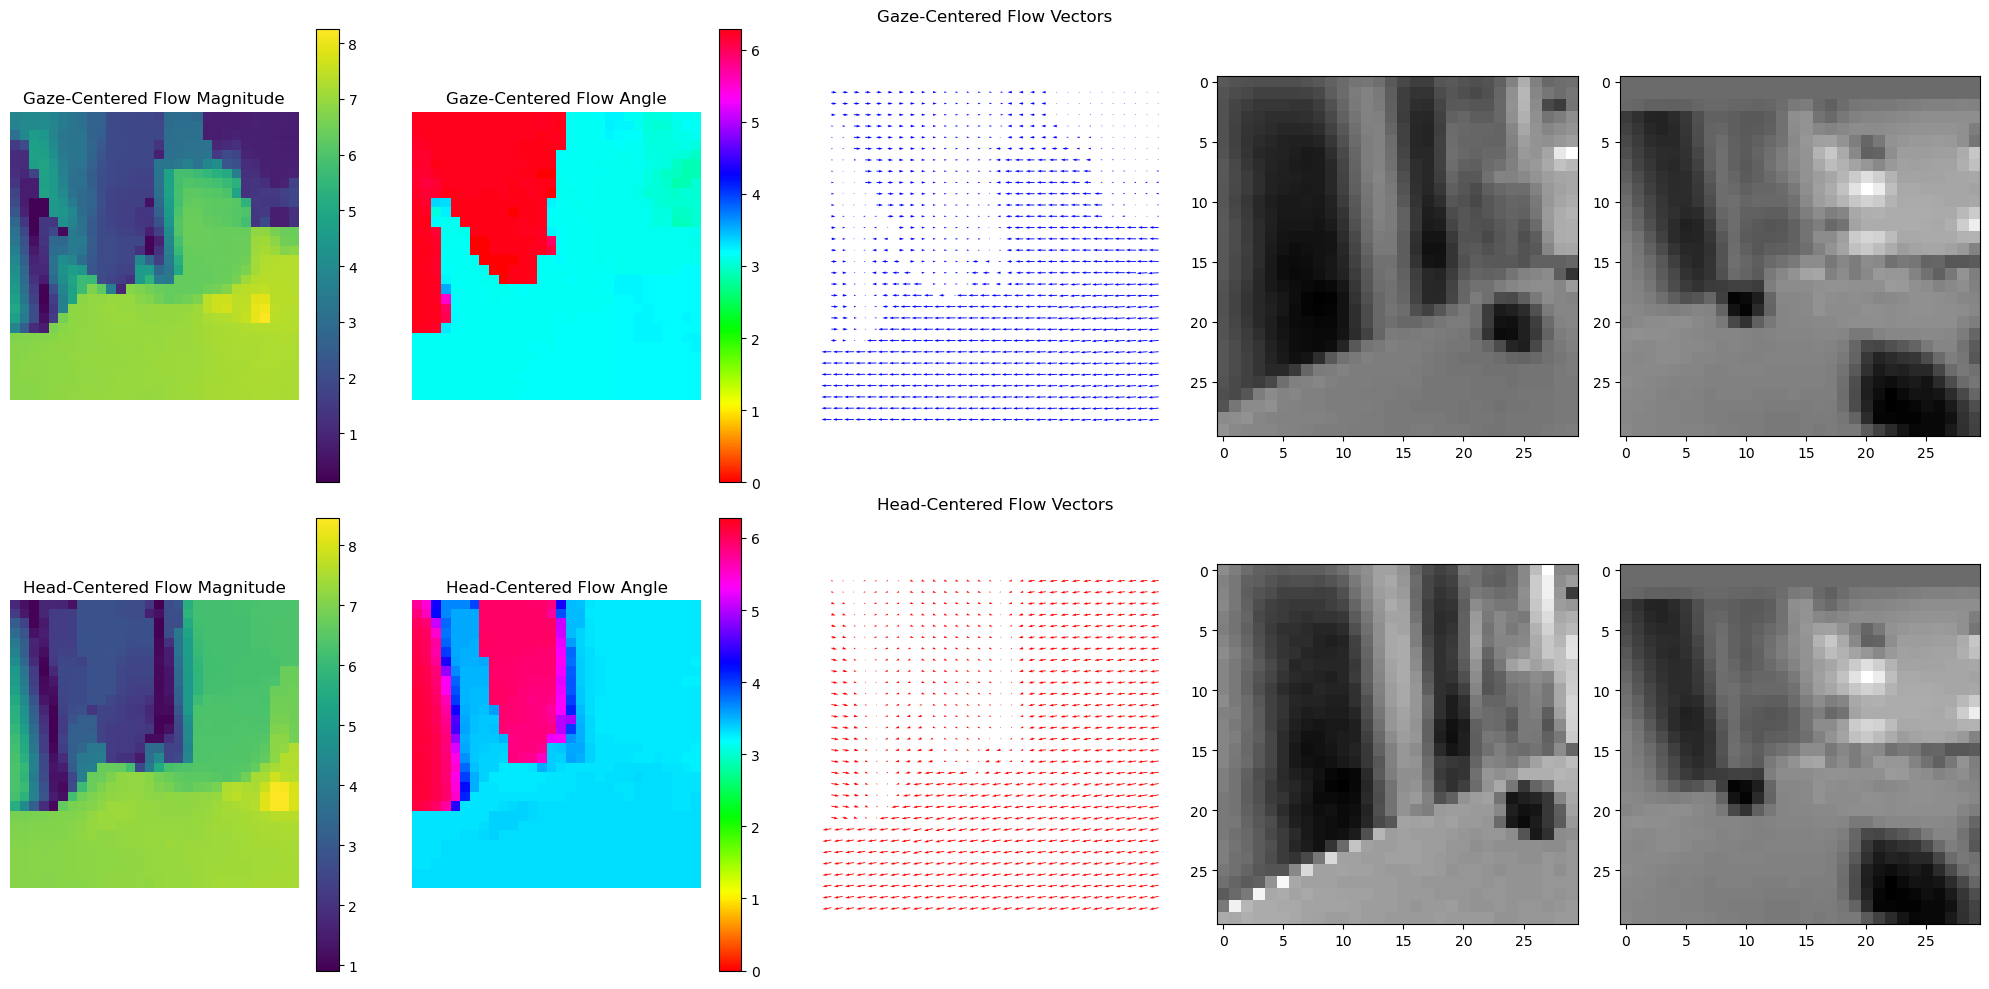

In [61]:
# Calculate vector components from magnitude and angle
this_frame = 1021

U_gaze = flow_mag_gaze[this_frame,...] * np.cos((flow_angle_gaze[this_frame,...]))
V_gaze = flow_mag_gaze[this_frame,...] * np.sin((flow_angle_gaze[this_frame,...]))
U_head = flow_mag_head[this_frame,...] * np.cos((flow_angle_head[this_frame,...]))
V_head = flow_mag_head[this_frame,...] * np.sin((flow_angle_head[this_frame,...]))
# Create a 2x3 subplot
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

origin = 'upper'

# First row for gaze-centered data
img1 = axs[0, 0].imshow(flow_mag_gaze[this_frame, :, :], cmap='viridis',origin=origin )
fig.colorbar(img1, ax=axs[0, 0])
axs[0, 0].set_title('Gaze-Centered Flow Magnitude')
axs[0, 0].axis('off')

img2 = axs[0, 1].imshow(flow_angle_gaze[this_frame, :, :], cmap='hsv',vmin=0, vmax=2*math.pi,origin=origin )
fig.colorbar(img2, ax=axs[0, 1])
axs[0, 1].set_title('Gaze-Centered Flow Angle')
axs[0, 1].axis('off')

qv1 = axs[0, 2].quiver(U_gaze, V_gaze, color='blue')
axs[0, 2].set_title('Gaze-Centered Flow Vectors')
axs[0, 2].axis('equal')
axs[0, 2].axis('off')
axs[0,2].invert_yaxis()

axs[0,3].imshow(frames_gaze_centered[this_frame,...],cmap='gray')

axs[0,4].imshow(frames_gaze_centered[this_frame+2,...],cmap='gray')

# Second row for head-centered data
img3 = axs[1, 0].imshow(flow_mag_head[this_frame, :, :], cmap='viridis',origin=origin )
fig.colorbar(img3, ax=axs[1, 0])
axs[1, 0].set_title('Head-Centered Flow Magnitude')
axs[1, 0].axis('off')

img4 = axs[1, 1].imshow(flow_angle_head[this_frame, :, :], cmap='hsv',vmin=0, vmax=2*math.pi,origin=origin )
fig.colorbar(img4, ax=axs[1, 1])
axs[1, 1].set_title('Head-Centered Flow Angle')
axs[1, 1].axis('off')

qv2 = axs[1, 2].quiver(U_head, V_head, color='red')
axs[1, 2].set_title('Head-Centered Flow Vectors')
axs[1, 2].axis('equal')
axs[1, 2].axis('off')

# Flip the Y-axis 
axs[1,2].invert_yaxis()

axs[1,3].imshow(frames_head_centered[this_frame,...],cmap='gray')
axs[1,4].imshow(frames_gaze_centered[this_frame+2,...],cmap='gray')

# Show the plot
plt.tight_layout()
plt.show()


viscm not found, falling back on simple display


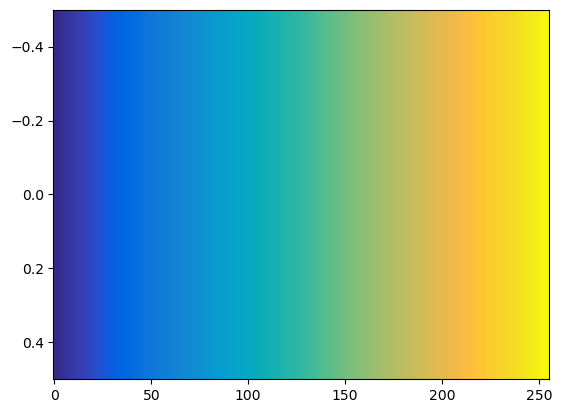

In [19]:
# NOTE:
# This is a copy of "parula" from MATLAB. We don't claim any rights to this
# file, but The Mathworks does. Consult them and/or a lawyer if you want to
# use it.

from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
# For use of "viscm view"
test_cm = parula_map

if __name__ == "__main__":

    try:
        from viscm import viscm
        viscm(parula_map)
    except ImportError:
        print("viscm not found, falling back on simple display")
        plt.imshow(np.linspace(0, 100, 256)[None, :], aspect='auto',
                   cmap=parula_map)
    plt.show()


In [57]:
frames =  frames_gaze_centered[1020:1030,...]# Parameters for the video writer 
frame_height, frame_width = frames.shape[1], frames.shape[2] 
fps = 20 # Adjust FPS as needed 
# Initialize the video writer 
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height)) 
# Loop through the frames and write to the video file 
for frame in frames: # Convert each frame to a format compatible with OpenCV 
    frame_rgb = (frame * 255).astype(np.uint8) # Convert to 8-bit and scale if needed 
    frame_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_GRAY2BGR) # Convert grayscale to RGB if needed 
    out.write(frame_rgb) # Release the video writer 
out.release()
    


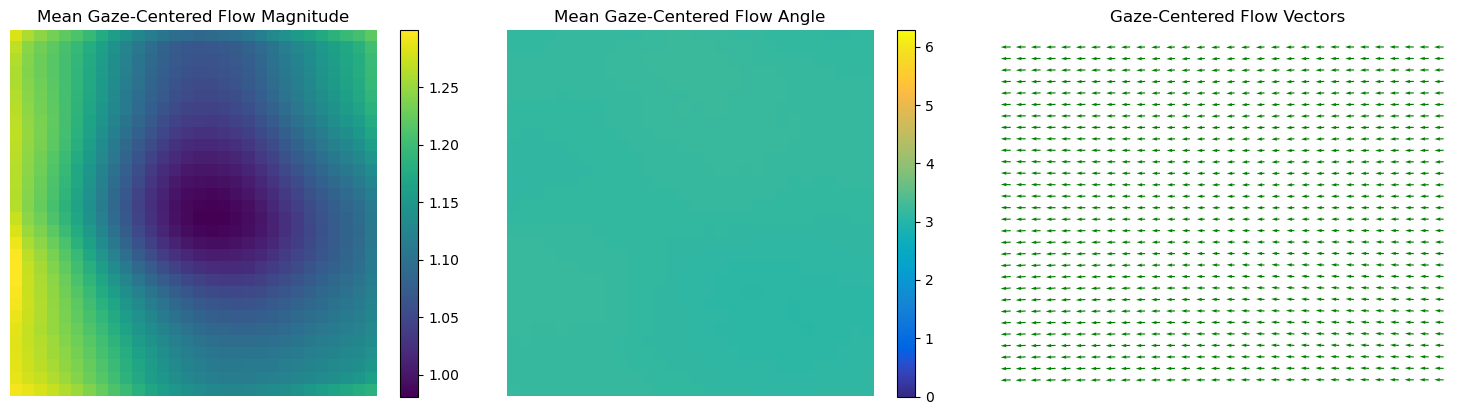

In [62]:

# mean_flow_mag_gaze = np.mean(flow_mag_gaze[idx], axis=0)
# mean_flow_angle_gaze = np.mean(flow_angle_gaze[idx], axis=0)
# mean_flow_mag_head = np.mean(flow_mag_head[idx], axis=0)
# mean_flow_angle_head = np.mean(flow_angle_head[idx], axis=0)

# Assuming the arrays are 3D with the shape (time, height, width)
# Calculate the mean across the time dimension (axis=0)
mean_flow_mag_gaze = np.mean(flow_mag_gaze, axis=0)
mean_flow_angle_gaze = np.mean(flow_angle_gaze, axis=0)
mean_flow_mag_head = np.mean(flow_mag_head, axis=0)
mean_flow_angle_head = np.mean(flow_angle_head, axis=0)

# Create a matrix of X and Y coordinates to be used for vector field plotting
Y, X = np.mgrid[0:mean_flow_mag_gaze.shape[0], 0:mean_flow_mag_head.shape[1]]
U_gaze = mean_flow_mag_gaze * np.cos(mean_flow_angle_gaze)
V_gaze = mean_flow_mag_gaze * np.sin(mean_flow_angle_gaze)
U_head = mean_flow_mag_head * np.cos(mean_flow_angle_head)
V_head = mean_flow_mag_head * np.sin(mean_flow_angle_head)

# Create a 2x3 subplot grid, change from 2x2 to make room for vector fields
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.25))

# First row for gaze-centered data
img1 = axs[0].imshow(mean_flow_mag_gaze, cmap='viridis',origin=origin)
fig.colorbar(img1, ax=axs[0])
axs[0].set_title('Mean Gaze-Centered Flow Magnitude')
axs[0].axis('off')

img2 = axs[1].imshow(mean_flow_angle_gaze, cmap=parula_map, vmin=0,vmax=2*math.pi,origin=origin)
fig.colorbar(img2, ax=axs[1])
axs[1].set_title('Mean Gaze-Centered Flow Angle')
axs[1].axis('off')

quiv1 = axs[2].quiver(X[::, ::], Y[::, ::], U_gaze[::, ::], V_gaze[::, ::], color='green')
axs[2].set_title('Gaze-Centered Flow Vectors')
axs[2].axis('off')
axs[2].invert_yaxis()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

[-86.61717322834937, -45, -10, 7.182364479441965]


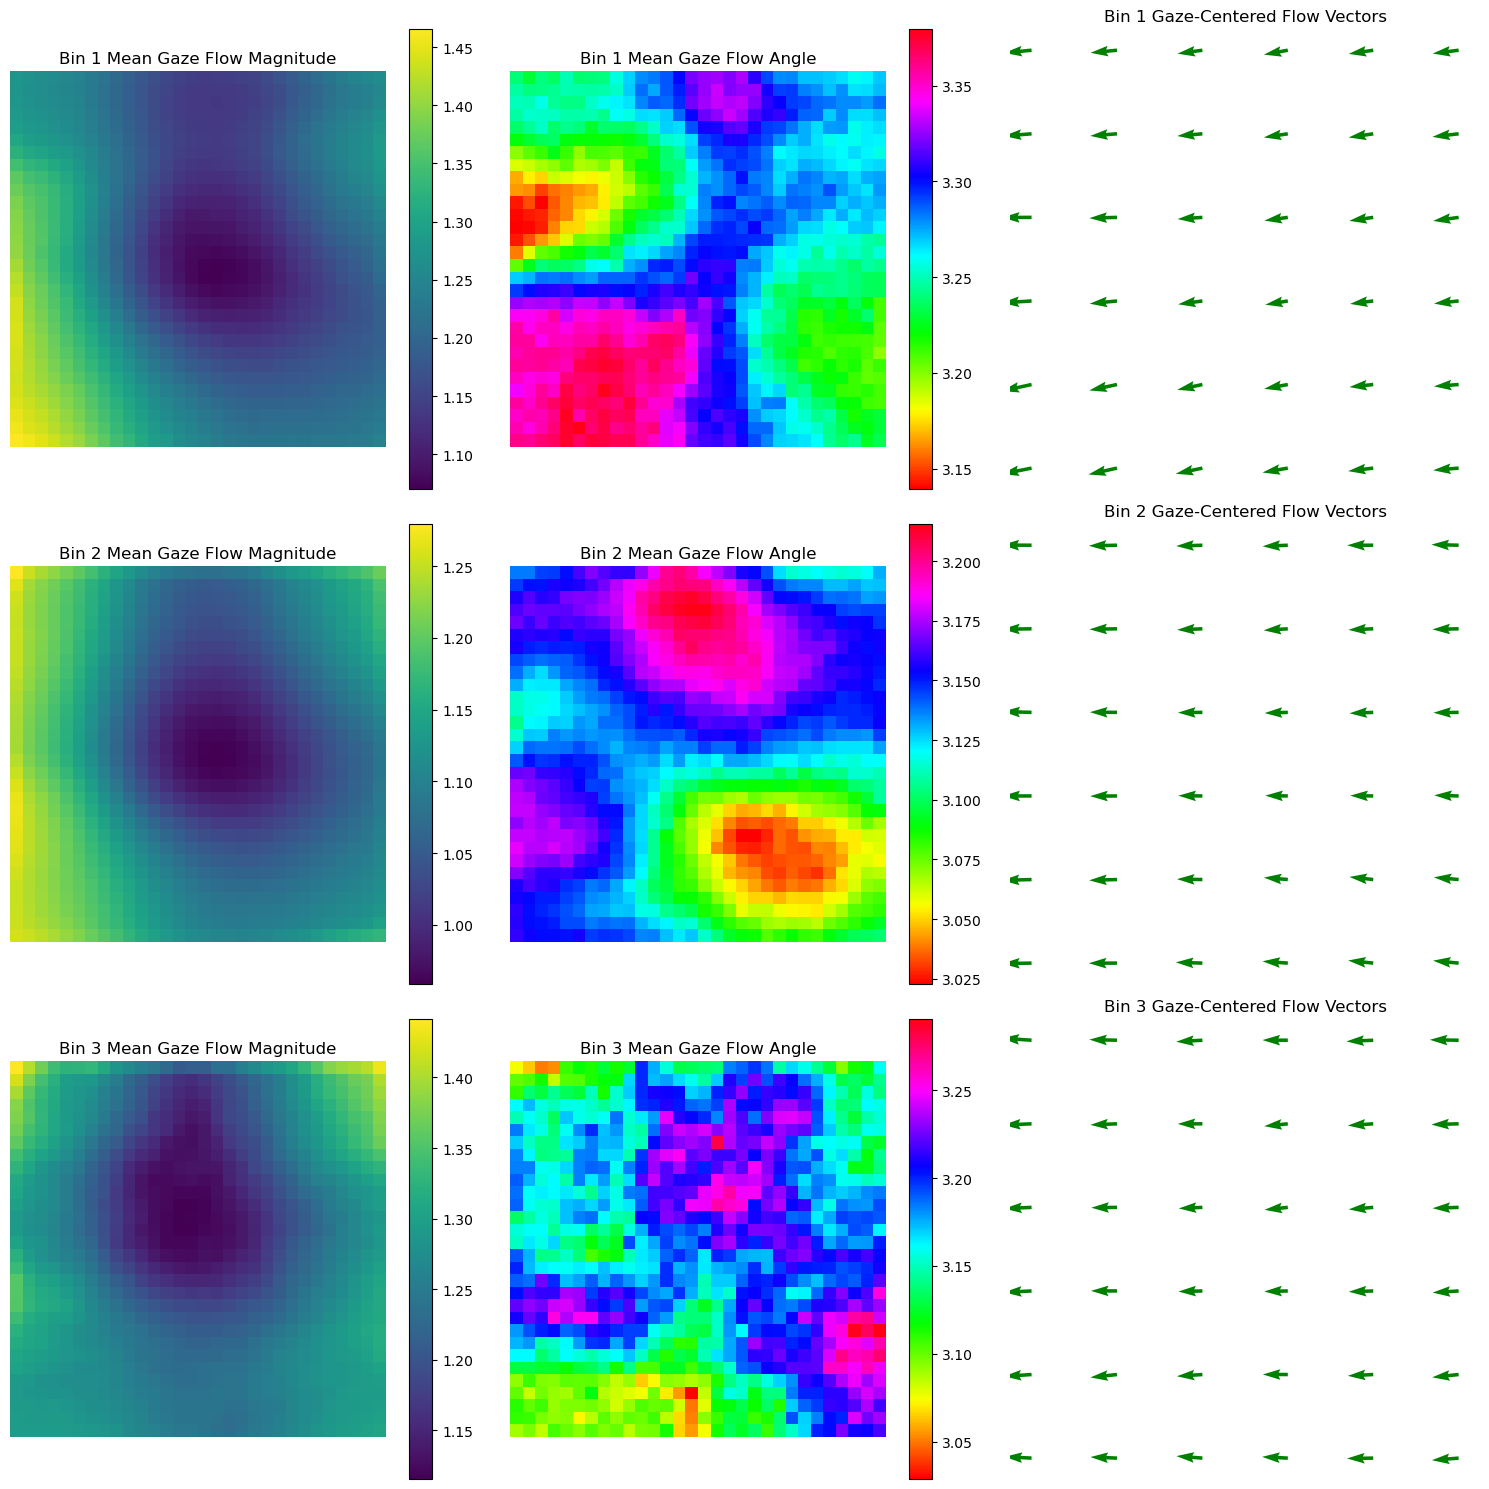

In [63]:
# Load the vertical position of the eye,
phi = f['model_phi'][:54352]

# Assuming 'phi' is already loaded as a 1D array corresponding to the vertical eye location over time
# Define the bins for classification of 'phi'
phi_bins = [phi.min(), -45, -10, phi.max()]
print(phi_bins)
# Create boolean masks for each phi range
masks = [(phi >= phi_bins[i]) & (phi < phi_bins[i+1]) for i in range(len(phi_bins)-1)]

# Initialize dictionaries to hold mean calculations for different metrics
mean_bins = {
    'mag': [],
    'angle': []
}

# Assuming 'flow_mag_gaze' and 'flow_angle_gaze' are datasets representing magnitude and angle of gaze flow
for mask in masks:
    mean_bins['mag'].append(np.mean(flow_mag_gaze[mask, :, :], axis=0))
    mean_bins['angle'].append(np.mean(flow_angle_gaze[mask, :, :], axis=0))

# Setting up a plot grid to visualize data: 3 bins x 3 metrics (magnitude, angle, vectors)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
Y, X = np.mgrid[0:mean_bins['mag'][0].shape[0], 0:mean_bins['mag'][0].shape[1]]

for i in range(3):
    # Calculate components for vector field visualization
    U_gaze = mean_bins['mag'][i] * np.cos(mean_bins['angle'][i])
    V_gaze = mean_bins['mag'][i] * np.sin(mean_bins['angle'][i])
    
    # Display mean magnitude and angle using imshow, and vector field using quiver
    img1 = axs[i, 0].imshow(mean_bins['mag'][i], cmap='viridis',origin=origin)
    fig.colorbar(img1, ax=axs[i, 0])
    axs[i, 0].set_title(f'Bin {i+1} Mean Gaze Flow Magnitude')
    axs[i, 0].axis('off')

    img2 = axs[i, 1].imshow(mean_bins['angle'][i], cmap='hsv',origin=origin)
    fig.colorbar(img2, ax=axs[i, 1])
    axs[i, 1].set_title(f'Bin {i+1} Mean Gaze Flow Angle')
    axs[i, 1].axis('off')

    quiv = axs[i, 2].quiver(X[::5, ::5], Y[::5, ::5], U_gaze[::5, ::5], V_gaze[::5, ::5], color='green')
    # plt.streamplot(X, Y, U_gaze, V_gaze, color='k', linewidth=2, arrowstyle='-', density=1.5)
    axs[i, 2].set_title(f'Bin {i+1} Gaze-Centered Flow Vectors')
    axs[i, 2].axis('off')
    axs[i,2].invert_yaxis()
    plt.savefig("mouse-flow-gaze.pdf", format="pdf", bbox_inches="tight") 

plt.tight_layout()
plt.show()


Threshold bins: [-29.953504449918633, -10, 10, 75.44386570816002]


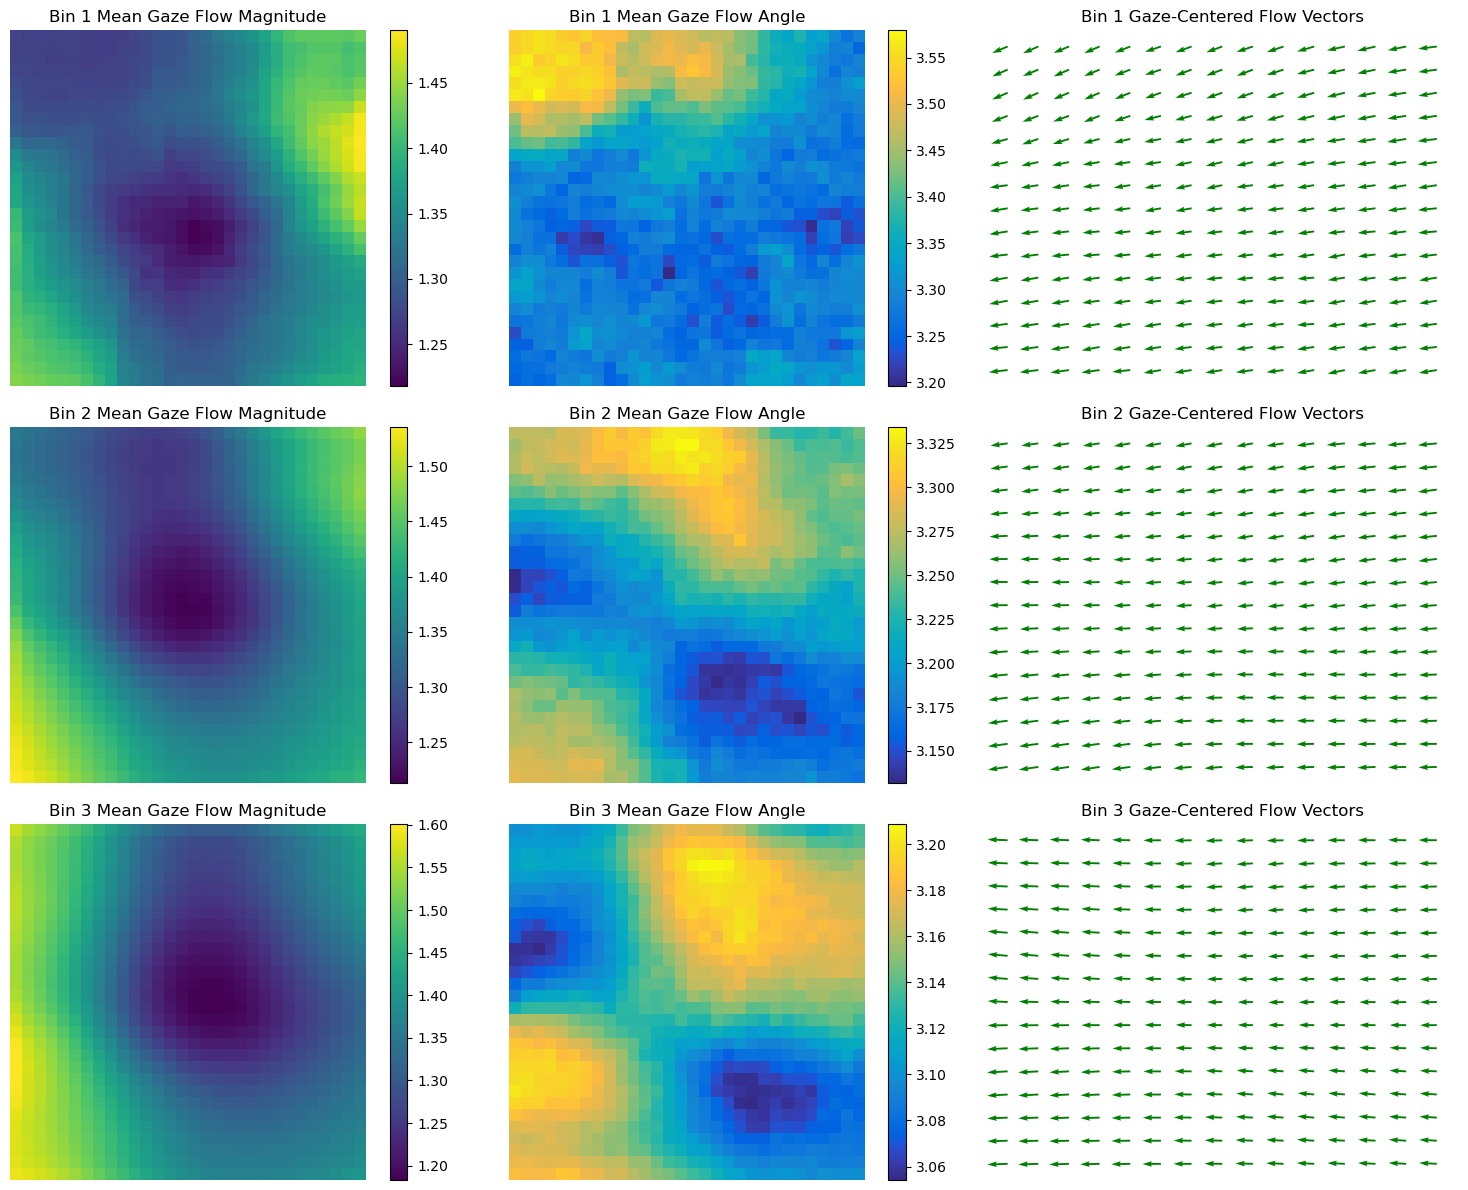

[-29.953504449918633, -10, 10, 75.44386570816002]


In [64]:
# Load the horizontal position of the eye
th = f['model_th'][:54352]
active = f['model_active'][:54352] > .5

# Define bins for classifying the vertical eye location data
th_bins = [th.min(), -10,10, th.max()]


print("Threshold bins:", th_bins)
# Create boolean masks for each threshold range
masks = [(th >= th_bins[i]) & (th < th_bins[i+1]) for i in range(len(th_bins) - 1)]


# Initialize dictionaries to hold mean calculations for magnitude and angle metrics
mean_bins = {'mag': [], 'angle': []}

# Apply mask to flow data inside the computing loop
for mask in masks:
    mean_mag = np.mean(flow_mag_gaze[mask&active], axis=0)
    mean_angle = np.mean(flow_angle_gaze[mask&active], axis=0)

    mean_bins['mag'].append(mean_mag)
    mean_bins['angle'].append(mean_angle)

# Set up a plot grid to visualize data: 3 bins x 3 metrics (magnitude, angle, vectors)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):  # cycle through the three bins
    # Calculate components for vector field visualization based on the mean magnitudes and angles
    U_gaze = mean_bins['mag'][i] * np.cos(mean_bins['angle'][i])
    V_gaze = mean_bins['mag'][i] * np.sin(mean_bins['angle'][i])
    
    # Display mean magnitude using imshow
    img1 = axs[i, 0].imshow(mean_bins['mag'][i], cmap='viridis', origin=origin)
    fig.colorbar(img1, ax=axs[i, 0])
    axs[i, 0].set_title(f'Bin {i+1} Mean Gaze Flow Magnitude')
    axs[i, 0].axis('off')

    # Display mean angle using imshow
    img2 = axs[i, 1].imshow(mean_bins['angle'][i], cmap=parula_map, origin=origin)
    fig.colorbar(img2, ax=axs[i, 1])
    axs[i, 1].set_title(f'Bin {i+1} Mean Gaze Flow Angle')
    axs[i, 1].axis('off')

    # Display vector field using quiver
    nn=2
    quiv = axs[i, 2].quiver(X[::nn, ::nn], Y[::nn, ::nn], U_gaze[::nn, ::nn], V_gaze[::nn, ::nn], color='green')
    axs[i, 2].set_title(f'Bin {i+1} Gaze-Centered Flow Vectors')
    axs[i, 2].axis('off')
    axs[i,2].invert_yaxis()

plt.savefig("mouse-flow-gaze.pdf", format="pdf", bbox_inches="tight") 
plt.tight_layout()
plt.show()
print(th_bins)

Threshold bins: [0.0011457103371222397, 5, 10, 15.243357045657483]


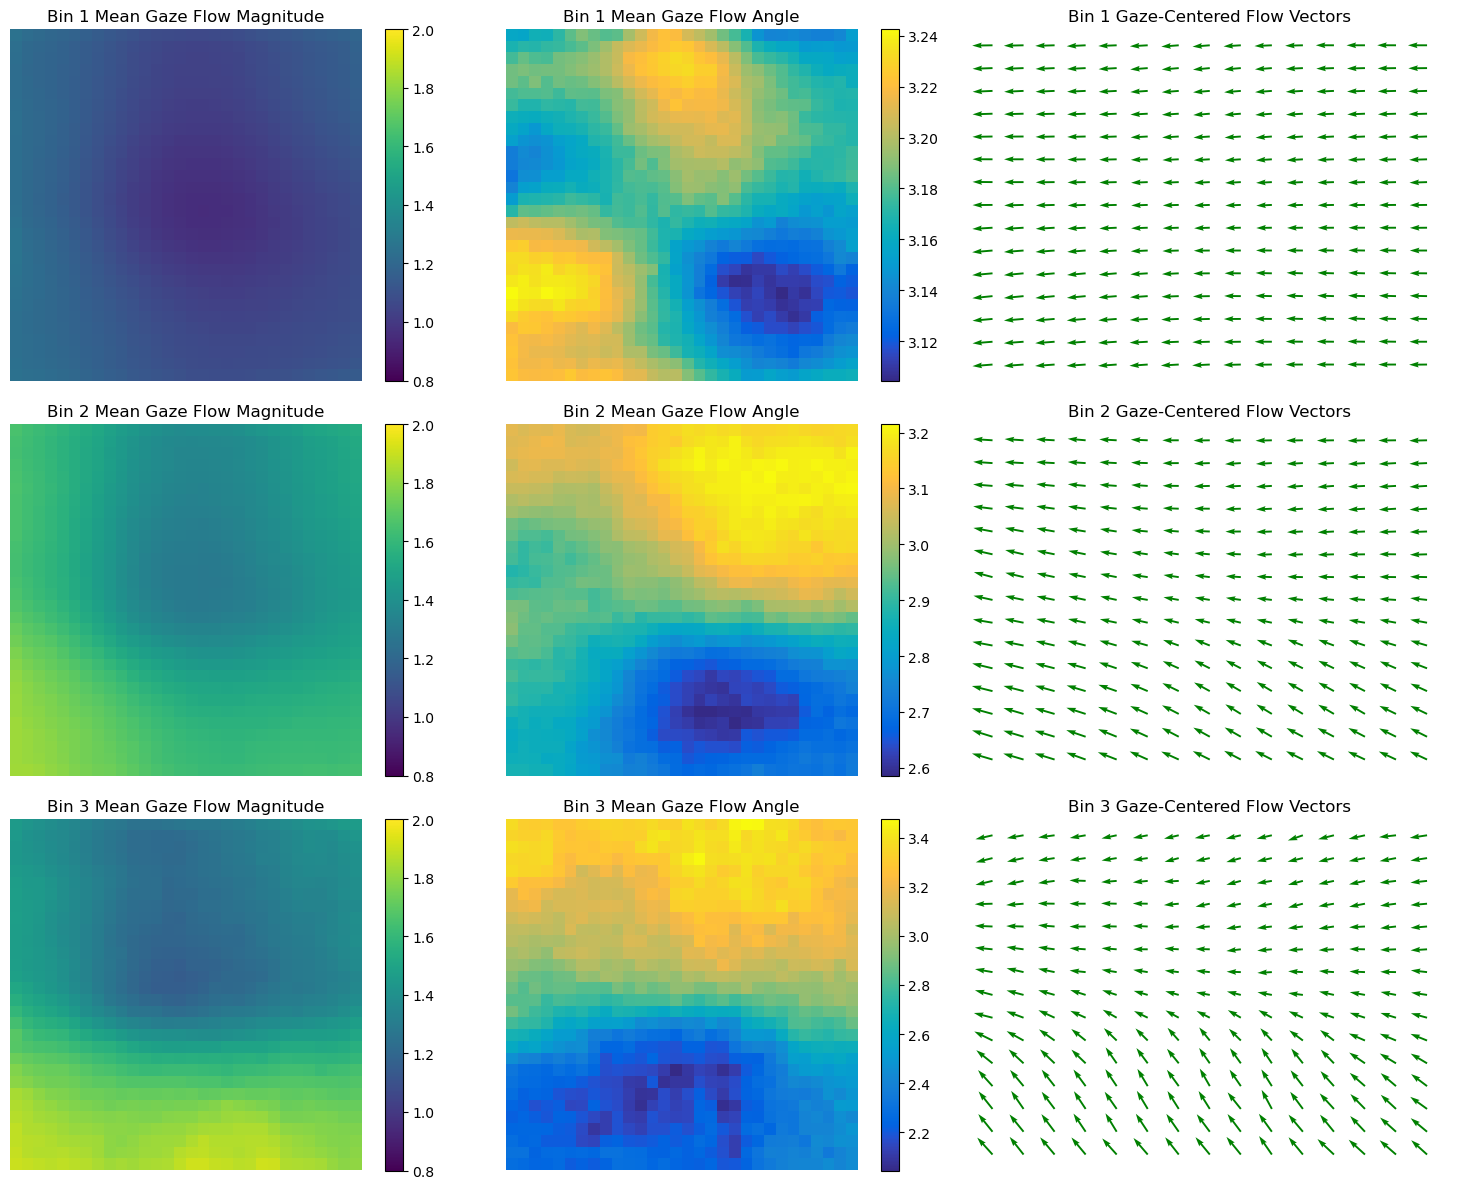

[0.0011457103371222397, 5, 10, 15.243357045657483]


In [65]:
# Load the horizontal position of the eye
th = f['model_speed'][:54352]

# Define bins for classifying the vertical eye location data
th_bins = [th.min(),5 ,10, th.max()]


print("Threshold bins:", th_bins)
# Create boolean masks for each threshold range
masks = [(th >= th_bins[i]) & (th < th_bins[i+1]) for i in range(len(th_bins) - 1)]


# Initialize dictionaries to hold mean calculations for magnitude and angle metrics
mean_bins = {'mag': [], 'angle': []}

# Apply mask to flow data inside the computing loop
for mask in masks:
    mean_mag = np.mean(flow_mag_gaze[mask], axis=0)
    mean_angle = np.mean(flow_angle_gaze[mask], axis=0)

    mean_bins['mag'].append(mean_mag)
    mean_bins['angle'].append(mean_angle)

# Set up a plot grid to visualize data: 3 bins x 3 metrics (magnitude, angle, vectors)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):  # cycle through the three bins
    # Calculate components for vector field visualization based on the mean magnitudes and angles
    U_gaze = mean_bins['mag'][i] * np.cos(mean_bins['angle'][i])
    V_gaze = mean_bins['mag'][i] * np.sin(mean_bins['angle'][i])
    
    # Display mean magnitude using imshow
    img1 = axs[i, 0].imshow(mean_bins['mag'][i], cmap='viridis', origin=origin,vmin=.80, vmax=2.0)
    fig.colorbar(img1, ax=axs[i, 0])
    axs[i, 0].set_title(f'Bin {i+1} Mean Gaze Flow Magnitude')
    axs[i, 0].axis('off')

    # Display mean angle using imshow
    img2 = axs[i, 1].imshow(mean_bins['angle'][i], cmap=parula_map, origin=origin)
    fig.colorbar(img2, ax=axs[i, 1])
    axs[i, 1].set_title(f'Bin {i+1} Mean Gaze Flow Angle')
    axs[i, 1].axis('off')

    # Display vector field using quiver
    nn=2
    quiv = axs[i, 2].quiver(X[::nn, ::nn], Y[::nn, ::nn], U_gaze[::nn, ::nn], V_gaze[::nn, ::nn], color='green')
    axs[i, 2].set_title(f'Bin {i+1} Gaze-Centered Flow Vectors')
    axs[i, 2].axis('off')
    axs[i,2].invert_yaxis()

plt.savefig("mouse-flow-by-speed.pdf", format="pdf", bbox_inches="tight") 
plt.tight_layout()
plt.show()
print(th_bins)

In [27]:
th.max()

15.243357045657483

In [32]:
# Matlab Nicole Rust energy model.

In [33]:
f.keys()

<KeysViewHDF5 ['model_active', 'model_eyerad', 'model_gz', 'model_nsp', 'model_phi', 'model_pitch', 'model_roll', 'model_speed', 'model_t', 'model_th', 'model_vid_sm', 'model_vid_sm_shift', 'unit_nums']>

In [1]:

# model_th is the horizontal position of the ey
# model_phi is the vertical position of the eye
# model_pitch is the vertical angle of the head
# model_roll is the rotation angle of the head
# model_gz is the yaw of the head
# model_speed is the speed of the animal



-37.74960088281868 53.75953685877234


(array([4.0000e+00, 5.5000e+01, 8.8000e+02, 5.3300e+03, 1.8512e+04,
        1.8748e+04, 9.3630e+03, 1.2860e+03, 1.5800e+02, 1.7000e+01]),
 array([-37.74960088, -28.59868711, -19.44777333, -10.29685956,
         -1.14594579,   8.00496799,  17.15588176,  26.30679554,
         35.45770931,  44.60862308,  53.75953686]),
 <BarContainer object of 10 artists>)

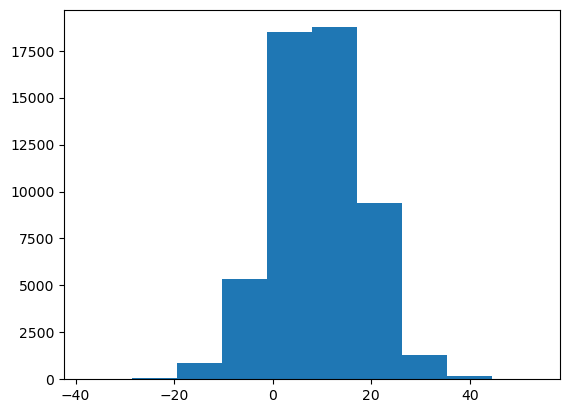

In [10]:
# visualizing the rotational angle of the head

head_roll = f['model_roll'][:]
print(np.nanmin(head_roll),np.nanmax(head_roll))

plt.hist(f['model_roll']


-73.21091713320263 63.38692925156473


(array([1.7000e+01, 3.5100e+02, 4.8550e+03, 1.7776e+04, 2.0911e+04,
        7.3440e+03, 2.3180e+03, 6.3800e+02, 1.0800e+02, 3.5000e+01]),
 array([-73.21091713, -59.55113249, -45.89134786, -32.23156322,
        -18.57177858,  -4.91199394,   8.7477907 ,  22.40757534,
         36.06735997,  49.72714461,  63.38692925]),
 <BarContainer object of 10 artists>)

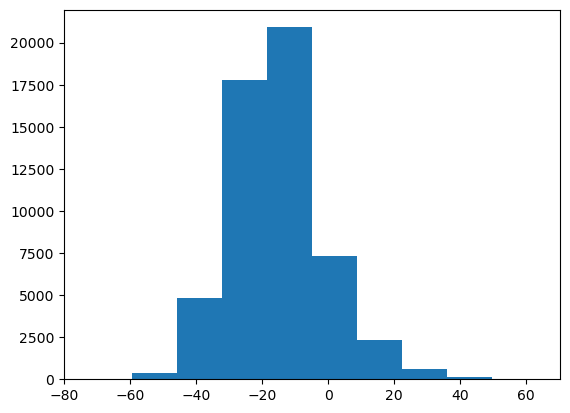

In [11]:
head_roll = f['model_pitch'][:]
print(np.nanmin(head_roll),np.nanmax(head_roll))

plt.hist(f['model_pitch'])